In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import xgboost as xgb


In [28]:
df = pd.read_csv(r"C:\Users\pasch\Beam-dynamics-surrogate-model\beam_deflection_dataset.csv")

In [29]:
df.head()

,k0,k1,damping,velocity,w_max
0,3.824946e+07,246086.429205,0,50.137138,0.000163
1,6.500999e+07,197732.221959,0,37.772646,0.000105
2,5.195376e+07,231687.128608,0,44.868033,0.000125
3,5.789096e+07,234723.811707,0,19.353973,0.000113
4,7.587654e+07,242295.458148,0,56.473185,0.000096


In [30]:
df.shape

(5000, 5)

In [31]:
df.columns

Index(['k0', 'k1', 'damping', 'velocity', 'w_max'], dtype='object')

In [32]:
# Define features and target variable
X = df.drop('w_max', axis=1)
y = df['w_max']

In [33]:
# Quick sanity check
print(X.shape, y.shape)

(5000, 4) (5000,)


In [34]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
xgb_base = XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
xgb_base.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [36]:
# Evaluate Base Model
y_pred_base = xgb_base.predict(X_test)
r2_base = r2_score(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
mae_base = mean_absolute_error(y_test, y_pred_base)

print("Baseline Model Performance:")
print(f"R²: {r2_base:.4f}")
print(f"RMSE: {rmse_base:.4f}")
print(f"MAE: {mae_base:.4f}")

Baseline Model Performance:
R²: 0.9872
RMSE: 0.0000
MAE: 0.0000


In [37]:
# Hyperparameter Tuning with Grid Search
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [4, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.03, 0.05, ...], 'max_depth': [4, 6], 'n_estimators': [300, 500], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [38]:
# Train Optimized Model
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [39]:
grid_search.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': 4,
 'n_estimators': 300,
 'subsample': 0.8}

In [40]:
# Final Model Evaluation
y_pred = best_xgb.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Optimized Model Performance:")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Optimized Model Performance:
R²: 0.9870
RMSE: 0.0000
MAE: 0.0000


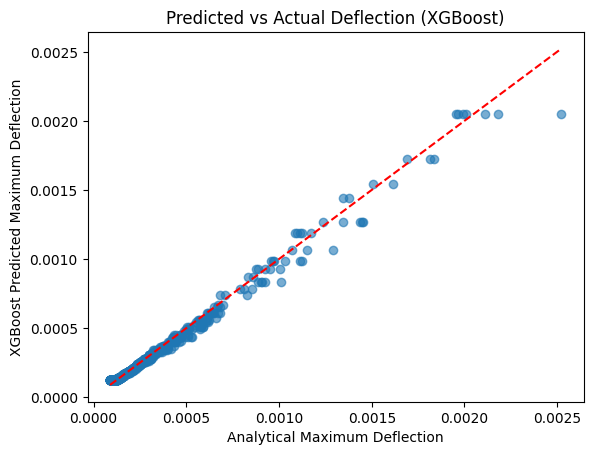

In [41]:
# Predicted vs Actual Plot
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--"
)
plt.xlabel("Analytical Maximum Deflection")
plt.ylabel("XGBoost Predicted Maximum Deflection")
plt.title("Predicted vs Actual Deflection (XGBoost)")
plt.show()

In [43]:
# Feature Importance Plot
importance = best_xgb.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

feature_importance_df.head(10)

,Feature,Importance
0,k0,1.0
1,k1,0.0
2,damping,0.0
3,velocity,0.0
